# Import Libraries

In [1]:
#access google drive
#from google.colab import drive

# data handling
import pandas as pd
import numpy as np
from collections import Counter

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# load numpy array from csv file
from numpy import loadtxt

#for splitting our data
from sklearn.model_selection import train_test_split

#plotting performance
import matplotlib.pyplot as plt

In [2]:
#get data from google drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utility Functions
Custom functions to help with handling the data

In [3]:
def encode_text(text, encode_type):
  """
  Input txt and outputs tokenised text.
  encode_type: bow = encode documents into vector where the coefficient for 
  each token is based on counting words
  """
  if(encode_type == 'bow'):
    encoder = Tokenizer()# create the tokenizer
    encoder.fit_on_texts(text)
    bow = encoder.texts_to_matrix(text, mode='count')
    # summarize what was learned
    print("Encoder Summary:\n")
    print(encoder.word_counts)
    print(encoder.document_count)
    print(encoder.word_index)
    print(encoder.word_docs)
    print(type(bow))
    print(bow.shape) #8.26gb / 23677 = 0.00035 GB/column if saved to file and 200205 * 0.00035 = 70GB if saved to file!
    return bow
  elif(encode_type == 'one-hot'):
    labels = pd.get_dummies(text).values
    print(labels.shape)
    return labels


# On-the-fly Word Embeddings

## SectionName (target)

### Load prepared SectionName dataset

In [4]:
y = pd.read_csv('./data/y_raw.csv') #sectionName only #/content/drive/MyDrive
y.head()

,sectionName
0,football
1,sport
2,world news
3,sport
4,art design


In [5]:
y = y.sectionName.values

### One-Hot-Encode SectionName

In [6]:
y = encode_text(y, encode_type='one-hot')

(14983, 82)


## WebTitle (Features)

### Bag-Of-Words

#### Load prepared webTitle dataset

In [7]:
X = pd.read_csv('./data/X_raw_wt.csv') #WebTitle only #/content/drive/MyDrive
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [8]:
X = X.webTitle.values

#### Encode Bag-of-Words Representation

In [9]:
X = encode_text(X, encode_type='bow')

Encoder Summary:

OrderedDict([('saido', 1), ('berahino', 1), ('right', 91), ('attitude', 3), ('hes', 25), ('fit', 16), ('says', 515), ('west', 108), ('broms', 1), ('pulis', 1), ('angelique', 1), ('kerber', 1), ('aims', 16), ('dislodge', 1), ('serena', 9), ('williams', 59), ('world', 295), ('no1', 3), ('spot', 20), ('family', 95), ('building', 13), ('refugee', 35), ('shadow', 15), ('isis', 19), ('exeter', 13), ('keep', 79), ('saracens', 19), ('sights', 5), ('bonus', 11), ('point', 34), ('win', 148), ('worcester', 5), ('exposed', 19), ('photographys', 1), ('fabulous', 5), ('fakes', 2), ('bank', 81), ('england', 279), ('governor', 12), ('caught', 14), ('bluffing', 1), ('interest', 25), ('rates', 25), ('senior', 15), ('tory', 73), ('urges', 41), ('eurosceptics', 1), ('show', 106), ('integrity', 8), ('vote', 82), ('leave', 70), ('eu', 142), ('holding', 7), ('back', 233), ('growth', 23), ('solar', 15), ('power', 92), ('herons', 1), ('review', 977), ('feral', 2), ('smash', 5), ('grab', 10), 

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets
Next, 10% of the data was split off for testting, 10% for validation and the remaining 80% was used as for training data.

In [10]:
#first split data for training and test data (90:10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=42)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("\n")
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_train.shape)
print("\n")
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (11985, 23677)
Training labels shape: (11985, 82)


Validation data shape: (1499, 23677)
Validation labels shape: (11985, 82)


Test data shape: (1499, 23677)
Test labels shape: (1499, 82)


In [11]:
# Reduce word amount to speed up training
truncate = 237 #592 #1183 #2368 #6000 # 23677 
max_words = 23681 #our vocab value we found during data cleaning
seq_len = truncate

In [12]:

X_train = X_train[:, :truncate]
X_test = X_test[:, :truncate]
X_val = X_val[:, :truncate]

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("\n")
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_train.shape)
print("\n")
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle BOW
Input will be passed to an basic RNN layer - sequences will be generated 

In [13]:
RNN_model = tf.keras.Sequential()

In [14]:
#batch size (numer of observations), #number of columns (timesteps), just have 1 indicator but can increase with more
RNN_model.add(layers.Embedding(input_dim=max_words, 
                           output_dim=50,
                           input_length=seq_len))

In [15]:
RNN_model.add(layers.SimpleRNN(8))#embedding dimension #seq_len

In [16]:
RNN_model.add(layers.Dropout(0.2))

In [17]:
RNN_model.add(layers.Dense(y.shape[1], activation='softmax'))

In [18]:
RNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 237, 50)           1184050   
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 472       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 82)                738       
                                                                 
Total params: 1,185,260
Trainable params: 1,185,260
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 102s 264ms/step - loss: 3.6547 - accuracy: 0.0855 - val_loss: 3.3086 - val_accuracy: 0.1254
Epoch 2/10
263/375 [====================>.........] - ETA: 26s - loss: 3.3450 - accuracy: 0.1000

#### Evaluation of Simple RNN Model using webTitle Bag of words 

In [58]:
print("RNN - WebTitle - BOW")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle - BOW
47/47 - 1s - loss: 3.3081 - accuracy: 0.0894 - 926ms/epoch - 20ms/step
RNN Test Loss 3.308
RNN Test Accuracy 0.089


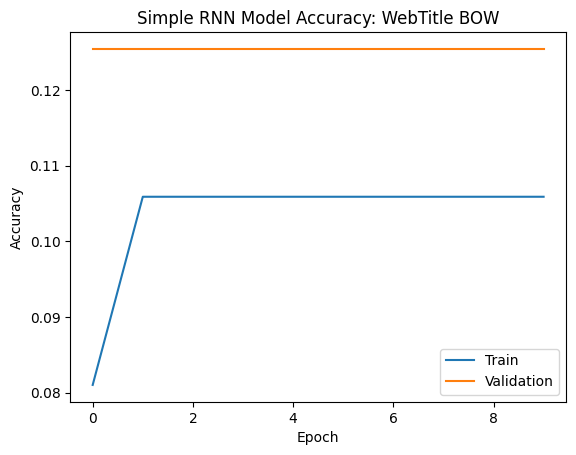

In [59]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Simple RNN Model Accuracy: WebTitle BOW')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

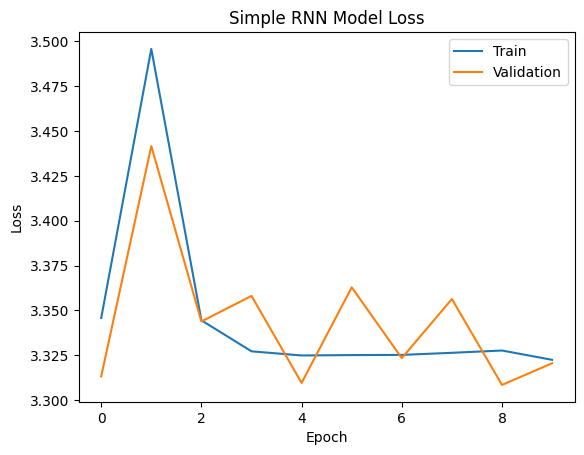

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Simple RNN Model Loss: WebTitle BOW')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Save Simple RNN Model using webTitle Bag of words 

In [ ]:
RNN_model.save('/content/drive/MyDrive/data/rnn_model-wt-bow')

### Sequence from webTitle

In [ ]:
wt_sequences = encode_wt.texts_to_sequences(df.webTitle.values)
X_t2s_wt = pad_sequences(wt_sequences, padding='post', truncating='post', maxlen=seq_len_wt)

In [ ]:
X_t2s_wt

array([[11115, 11116,   118, ...,     0,     0,     0],
       [11119, 11120,  1430, ...,     0,     0,     0],
       [  105,  1775,   534, ...,     0,     0,     0],
       ...,
       [ 3954,   215,   252, ...,     0,     0,     0],
       [ 1536,  4797,    42, ...,     0,     0,     0],
       [11006,   911, 10361, ...,     0,     0,     0]], dtype=int32)

In [ ]:
X_t2s_wt.shape

(14983, 128)

In [ ]:
wt_bc_sequences = encode_wt_bc.texts_to_sequences(df.webTitle_bodyContent.values)
X_t2s_wt_bc = pad_sequences(wt_bc_sequences, padding='post', truncating='post', maxlen=seq_len_wt_bc)

In [ ]:
X_t2s_wt_bc

array([[42542, 37092,    62, ...,     0,     0,     0],
       [26864, 22351,  3413, ...,     0,     0,     0],
       [   79,   576,  2128, ...,     0,     0,     0],
       ...,
       [11541,   662,  1212, ...,     0,     0,     0],
       [ 3002, 10330,   206, ...,     0,     0,     0],
       [12301,   211, 24372, ...,     0,     0,     0]], dtype=int32)

In [ ]:
X_t2s_wt_bc.shape

(14983, 59755)

### WebTitle & BodyContent

#### Load prepared webTitle & BodyContent dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt_bc.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


#### Encode Bag-of-Words Representation

In [ ]:
X = encode_text(X, encode_type='bow')

#### Split webTitle & bodyContent into 80% training, 10% test & 10% validation datasets
Next, 10% of the data was split off for testting, 10% for validation and the remaining 80% was used as for training data.

In [ ]:
from sklearn.model_selection import train_test_split

#first split data for training and test data (90:10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=42)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (11977, 255)
Training labels shape: (11977, 76)
Validation data shape: (1497, 255)
Validation labels shape: (11977, 76)
Test data shape: (1498, 255)
Test labels shape: (1498, 76)


In [ ]:
max_words = 14953

In [ ]:
seq_len = 255

#### Build Simple RNN Model using webTitle & BodyContent Bag of words 
Input will be passed to an basic RNN layer - sequences will be generated 

In [ ]:
RNN_model = tf.keras.Sequential()

In [ ]:
RNN_model.add(layers.Embedding(input_dim=max_words, 
                           output_dim=82,
                           input_length=seq_len))

In [ ]:
RNN_model.add(layers.SimpleRNN(seq_len))#embedding dimension

In [ ]:
RNN_model.add(layers.Dense(y.shape[1], activation='softmax'))

In [ ]:
RNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 255, 82)           1226146   
                                                                 
 simple_rnn (SimpleRNN)      (None, 255)               86190     
                                                                 
 dense (Dense)               (None, 76)                19456     
                                                                 
Total params: 1,331,792
Trainable params: 1,331,792
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 136s 363ms/step - loss: 3.3458 - accuracy: 0.0871 - val_loss: 3.3132 - val_accuracy: 0.0741
Epoch 2/10
375/375 [==============================] - 137s 365ms/step - loss: 3.4958 - accuracy: 0.0788 - val_loss: 3.4416 - val_accuracy: 0.0822
Epoch 3/10
375/375 [==============================] - 124s 330ms/step - loss: 3.3445 - accuracy: 0.0857 - val_loss: 3.3438 - val_accuracy: 0.0728
Epoch 4/10
375/375 [==============================] - 126s 336ms/step - loss: 3.3272 - accuracy: 0.0882 - val_loss: 3.3581 - val_accuracy: 0.0902
Epoch 5/10
375/375 [==============================] - 124s 332ms/step - loss: 3.3249 - accuracy: 0.0874 - val_loss: 3.3096 - val_accuracy: 0.0721
Epoch 6/10
375/375 [==============================] - 130s 348ms/step - loss: 3.3251 - accuracy: 0.0872 - val_loss: 3.3629 - val_accuracy: 0.0782
Epoch 7/10
375/375 [==============================] - 126s 336ms/step - loss: 3.3252 - accuracy: 0.0875 - val_loss: 3.3234 -

#### Evaluation of Simple RNN Model using webTitle & BodyContent Bag of words 

In [ ]:
print("RNN - WebTitle & BodyContent - BOW")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", loss_and_metrics[0])
print("RNN Test Accuracy", loss_and_metrics[1])

47/47 - 4s - loss: 3.2785 - accuracy: 0.1121 - 4s/epoch - 79ms/step
RNN Test Loss 3.278456926345825
RNN Test Accuracy 0.11214952915906906


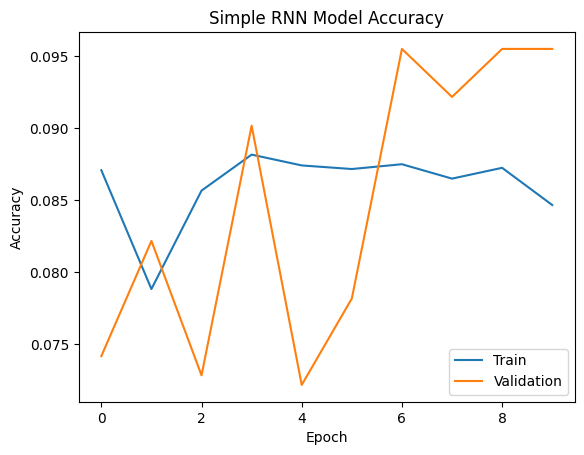

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Simple RNN Model Accuracy: WebTitle & BodyContent BOW')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

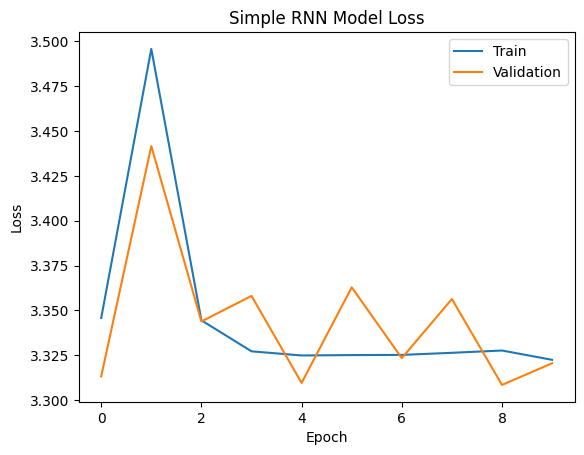

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Simple RNN Model Loss: WebTitle & BodyContent')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Save Simple RNN Model using webTitle & BodyContent Bag of words 

In [ ]:
RNN_model.save('/content/drive/MyDrive/data/rnn_model-wt-bc-bow')

## Pretrained Word Embeddings